In [1]:
!git clone https://github.com/thuml/Time-Series-Library/

fatal: destination path 'Time-Series-Library' already exists and is not an empty directory.


In [2]:
%cd Time-Series-Library/

/content/Time-Series-Library


In [3]:
!pip install -r requirements.txt

In [4]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

  Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl.metadata (992 bytes)
Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl (7.9 MB)


In [210]:
!pip install -U "pandas>=2.0.0"
import pandas as pd
data = pd.read_csv("forecasting_data.csv")
data = data.drop(columns=[col for col in data.columns if col.startswith("Un")])
print(data.head())
print(data.isna().sum())
data.reset_index(drop=True, inplace=True)
df = data

                기상관측일시  관측_습도  관측_기온     관측_대기압  예측_일사량   예측_습도  예측_절대습도  \
0  2024-01-01 00:00:00  85.23   3.82  764.46793     0.0  57.061    0.004   
1  2024-01-01 01:00:00  86.75   3.76  764.68855     0.0  58.348    0.004   
2  2024-01-01 02:00:00  86.43   3.04  765.05595     0.0  58.897    0.004   
3  2024-01-01 03:00:00  90.60   1.99  765.42151     0.0  58.438    0.004   
4  2024-01-01 04:00:00  92.59   1.25  765.61559     0.0  58.286    0.004   

   예측_기온      예측_대기압  
0  0.803  756.447675  
1  1.141  756.926064  
2  1.417  757.237152  
3  1.498  757.490636  
4  1.172  757.593964  
기상관측일시       0
관측_습도        1
관측_기온        1
관측_대기압       1
예측_일사량     336
예측_습도      336
예측_절대습도    336
예측_기온      336
예측_대기압     336
dtype: int64


In [211]:
import pandas as pd
import numpy as np
import torch
df.columns = df.columns.str.strip()
def create_sliding_windows(data, time_feats, mask, window_size):
    x_list, t_list, m_list = [], [], []
    for i in range(len(data) - window_size + 1):
        x_seq = data[i:i+window_size]
        t_seq = time_feats[i:i+window_size]
        m_seq = mask[i:i+window_size]
        x_seq = np.nan_to_num(x_seq, nan=0.0)
        x_list.append(x_seq)
        t_list.append(t_seq)
        m_list.append(m_seq)
    return (
        torch.tensor(np.array(x_list)).float(),
        torch.tensor(np.array(t_list)).float(),
        torch.tensor(np.array(m_list)).float()
    )

def preprocess_for_joint_input(df, window_size=96):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['기상관측일시'])

    predict_cols = [col for col in df.columns if col.startswith("예측_")]
    print(predict_cols)
    observe_cols = [col for col in df.columns if col.startswith("관측_")]
    feature_cols = predict_cols + observe_cols

    data = df[feature_cols].values.astype(np.float32)

    # 안정적인 정규화
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    std[std < 1e-3] = 1.0
    normed_data = (data - mean) / std
    normed_data = np.nan_to_num(normed_data, nan=0.0)

    # 시간 피처
    time_feats = pd.DataFrame({
        'hour': df['datetime'].dt.hour,
        'dayofweek': df['datetime'].dt.dayofweek,
        'month': df['datetime'].dt.month,
        'minute': df['datetime'].dt.minute
    }).values.astype(np.float32)

    # 마스크: 예측 컬럼만 NaN 고려
    predict_data = df[predict_cols].values.astype(np.float32)
    predict_mask = (~np.isnan(predict_data)).astype(float)
    full_mask = np.ones_like(data, dtype=np.float32)
    full_mask[:, :len(predict_cols)] = predict_mask

    return create_sliding_windows(normed_data, time_feats, full_mask, window_size), feature_cols, mean, std

In [213]:
(x, x_mark, mask), feature_cols, mean, std = preprocess_for_joint_input(df, window_size=96)

print("x shape:", x.shape)           # e.g., [10850, 96, 8]  (예측 5 + 관측 3)
print("x_mark shape:", x_mark.shape) # [10850, 96, 4]
print("mask shape:", mask.shape)     # [10850, 96, 8]
print("예측 대상 feature:", feature_cols[:5])

['예측_일사량', '예측_습도', '예측_절대습도', '예측_기온', '예측_대기압']
x shape: torch.Size([10850, 96, 8])
x_mark shape: torch.Size([10850, 96, 4])
mask shape: torch.Size([10850, 96, 8])
예측 대상 feature: ['예측_일사량', '예측_습도', '예측_절대습도', '예측_기온', '예측_대기압']


In [214]:
from torch.utils.data import Dataset

class CustomImputationDataset(Dataset):
    def __init__(self, x, x_mark, mask):
        self.x = x
        self.x_mark = x_mark
        self.mask = mask

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.x_mark[idx], self.mask[idx]

In [215]:
from models.TimesNet import Model
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import AdamW
import torch

class Config:
    task_name = 'imputation'
    seq_len =96
    # period_list = [2, 4, 8, 16, 32] 이거 코드 내부 바꿔야함
    label_len = 0
    pred_len = 0
    enc_in = 8      # 실제 feature 수로 나중에 바뀜
    c_out = 8
    d_model = 64
    d_ff = 128
    e_layers = 3
    top_k = 3
    dropout = 0.1
    embed = 'timeF'
    freq = 'h'
    num_kernels = 6
    num_class = 1

# 데이터 준비
(x, x_mark, mask), feature_cols, mean, std = preprocess_for_joint_input(df)
predict_len = 5  # 예측_* 개수

configs = Config()
configs.enc_in = x.shape[-1]
configs.c_out = x.shape[-1]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Model(configs).to(device)

dataset = CustomImputationDataset(x, x_mark, mask)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 손실 함수: SmoothL1Loss (Huber Loss)
criterion = nn.SmoothL1Loss()

# 옵티마이저: AdamW
optimizer = AdamW(model.parameters(), lr=1e-3)
# 학습 루프
for epoch in range(1):
    total_loss = 0
    model.train()

    for batch_idx, (x_b, t_b, m_b) in enumerate(loader):
        x_b, t_b, m_b = x_b.to(device), t_b.to(device), m_b.to(device)
        x_b = torch.nan_to_num(x_b, nan=0.0)
        t_b = torch.nan_to_num(t_b, nan=0.0)
        m_b = torch.nan_to_num(m_b, nan=0.0)

        output = model(x_b, t_b, None, None, m_b)

        if torch.isnan(output).any():
            if batch_idx % 10 == 0:
                print(f"🚫 NaN 발생 → [epoch {epoch+1}, batch {batch_idx}] 스킵")
            continue

        loss = criterion(
            output[:, :, :predict_len] * m_b[:, :, :predict_len],
            x_b[:, :, :predict_len] * m_b[:, :, :predict_len]
        )

        if torch.isnan(loss):
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"[Epoch {epoch+1} | Batch {batch_idx}] Loss: {loss.item():.4f}")

        total_loss += loss.item()

    print(f"✅ [Epoch {epoch+1}] 평균 Loss: {total_loss / len(loader):.4f}")

['예측_일사량', '예측_습도', '예측_절대습도', '예측_기온', '예측_대기압']
[Epoch 1 | Batch 0] Loss: 0.1907
[Epoch 1 | Batch 100] Loss: 0.0103
[Epoch 1 | Batch 200] Loss: 0.0147
[Epoch 1 | Batch 300] Loss: 0.0078
[Epoch 1 | Batch 400] Loss: 0.0068
[Epoch 1 | Batch 500] Loss: 0.0050
🚫 NaN 발생 → [epoch 1, batch 580] 스킵
[Epoch 1 | Batch 600] Loss: 0.0038
[Epoch 1 | Batch 700] Loss: 0.0046
[Epoch 1 | Batch 800] Loss: 0.0032
[Epoch 1 | Batch 900] Loss: 0.0029
[Epoch 1 | Batch 1000] Loss: 0.0036
🚫 NaN 발생 → [epoch 1, batch 1050] 스킵
[Epoch 1 | Batch 1100] Loss: 0.0029
[Epoch 1 | Batch 1200] Loss: 0.0023
[Epoch 1 | Batch 1300] Loss: 0.0023
✅ [Epoch 1] 평균 Loss: 0.0083


In [217]:
import matplotlib.pyplot as plt

def plot_imputation_result(x, mask, output, feature_names, sample_idx=0, feature_idx=0):
    """
    x         : 원본 입력 시계열 [B, L, C]
    mask      : 관측 마스크      [B, L, C]
    output    : 보간 결과        [B, L, C]
    sample_idx: 몇 번째 배치 샘플을 볼지
    feature_idx: 몇 번째 feature (예: 예측_기온이면 3번 등)

    feature_names: feature 이름 리스트 (예측_기온 등)
    """
    true = x[sample_idx, :, feature_idx].cpu().numpy()
    pred = output[sample_idx, :, feature_idx].detach().cpu().numpy()
    msk = mask[sample_idx, :, feature_idx].cpu().numpy()

    plt.figure(figsize=(12, 5))
    plt.plot(true, label='Ground Truth (with missing)', color='black')
    plt.plot(pred, label='Model Imputation', color='orange', linestyle='--')
    plt.scatter(np.where(msk == 0)[0], pred[msk == 0], color='red', label='Imputed Points')
    plt.title(f"Imputation - {feature_names[feature_idx]}")
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.grid(True)
    plt.show()


# 🔹 모델 추론 (검증 모드)
model.eval()
with torch.no_grad():
    x_sample, x_mark_sample, mask_sample = x[:8], x_mark[:8], mask[:8]
    x_sample = x_sample.to(device)
    x_mark_sample = x_mark_sample.to(device)
    mask_sample = mask_sample.to(device)

    output_sample = model(x_sample, x_mark_sample, None, None, mask_sample)

# 🔹 예측 칼럼 리스트만 추출
predict_cols = feature_cols[:5]

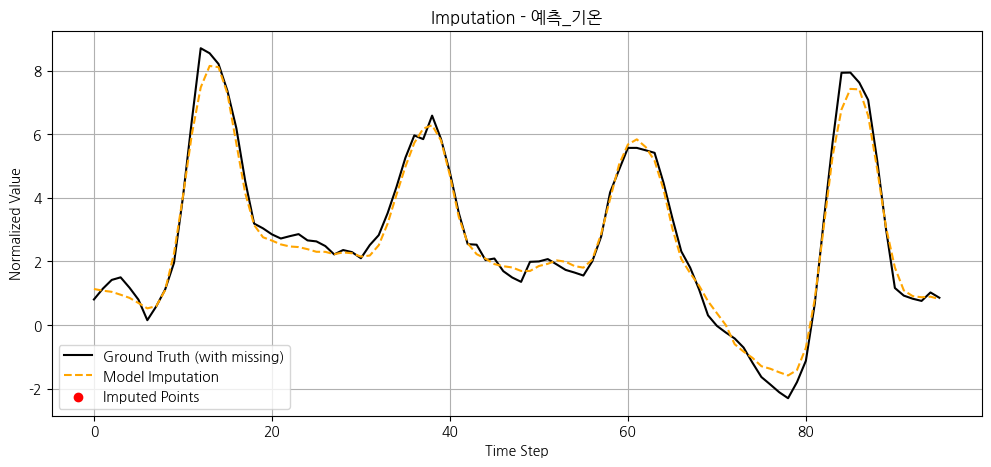

In [218]:
model.eval()
imputed_outputs = []

with torch.no_grad():
    for x_b, t_b, m_b in DataLoader(dataset, batch_size=128):
        x_b = x_b.to(device)
        t_b = t_b.to(device)
        m_b = m_b.to(device)

        x_b = torch.nan_to_num(x_b, nan=0.0)
        t_b = torch.nan_to_num(t_b, nan=0.0)
        m_b = torch.nan_to_num(m_b, nan=0.0)

        output = model(x_b, t_b, None, None, m_b)  # [B, 96, C]
        imputed_outputs.append(output.cpu())

# 모든 배치 결합
imputed_all = torch.cat(imputed_outputs, dim=0)  # [N, 96, C]

# 원본 정규화된 입력값 복사
x_filled = x.clone()

# 예측_* 영역만 복원
for i in range(predict_len):
    x_filled[:, :, i][mask[:, :, i] == 0] = imputed_all[:, :, i][mask[:, :, i] == 0]

# 역정규화 함수
def inverse_transform(x, mean, std):
    return x * torch.tensor(std).view(1, 1, -1) + torch.tensor(mean).view(1, 1, -1)

x_recovered = inverse_transform(x_filled, mean, std)

imputed_all_recovered = inverse_transform(imputed_all, mean, std)

# 예: sample_idx=0, feature_idx=3 (예측_기온)
plot_imputation_result(
    x_recovered, mask, imputed_all_recovered, feature_names=predict_cols,
    sample_idx=0, feature_idx=3
)

['예측_일사량', '예측_습도', '예측_절대습도', '예측_기온', '예측_대기압']


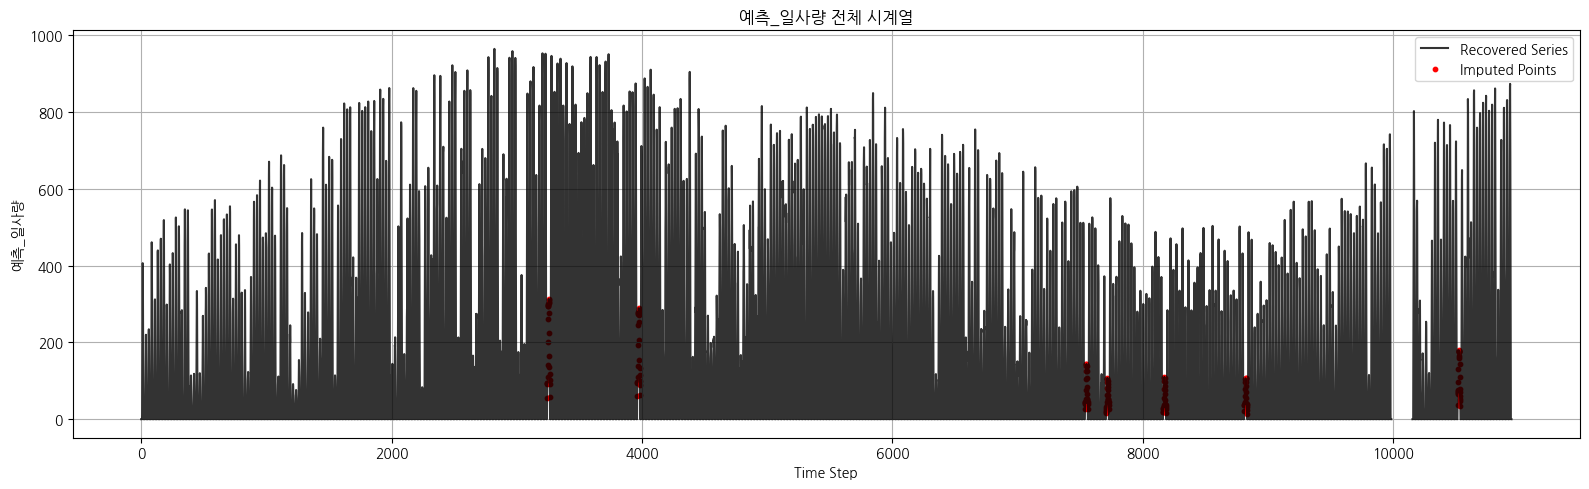

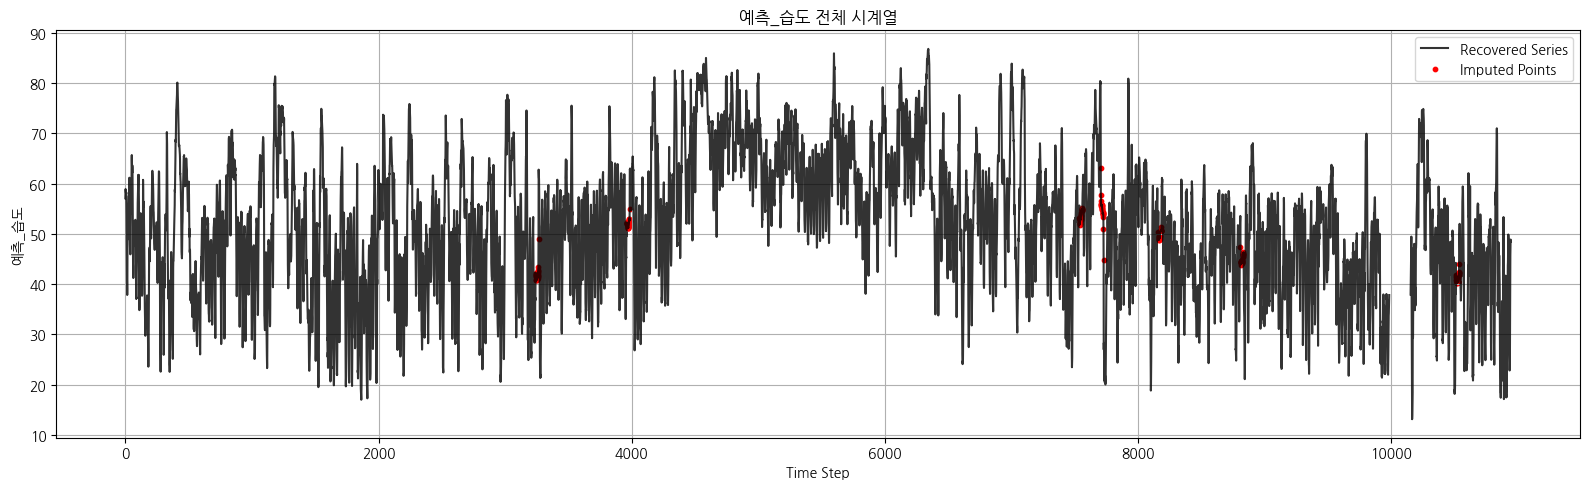

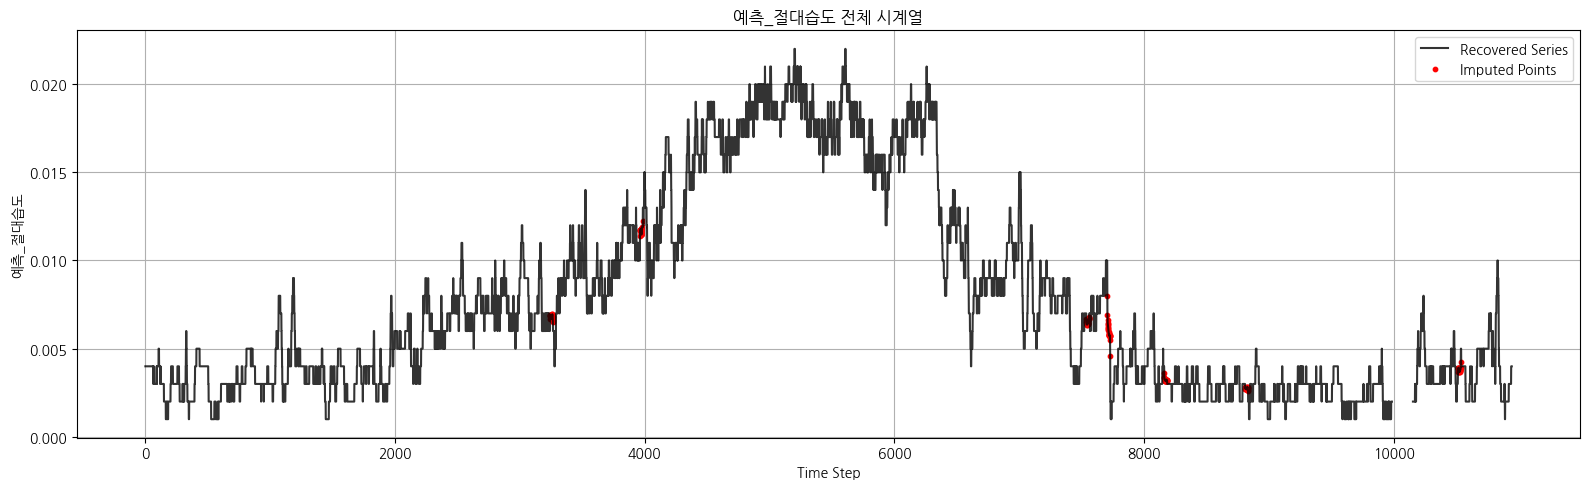

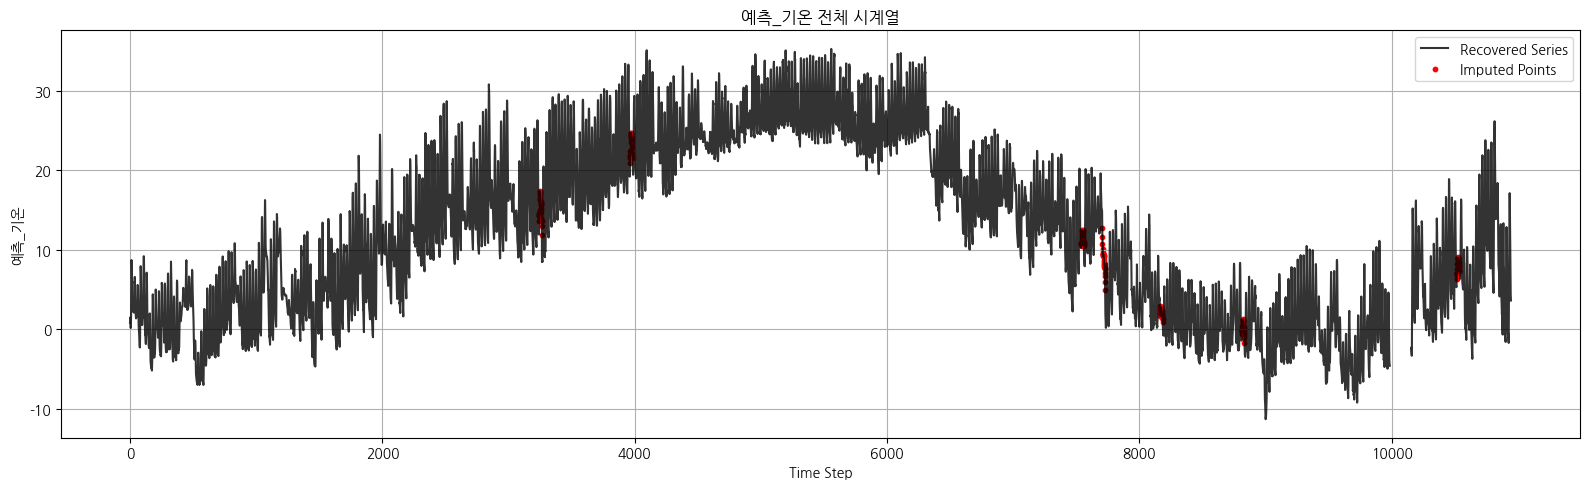

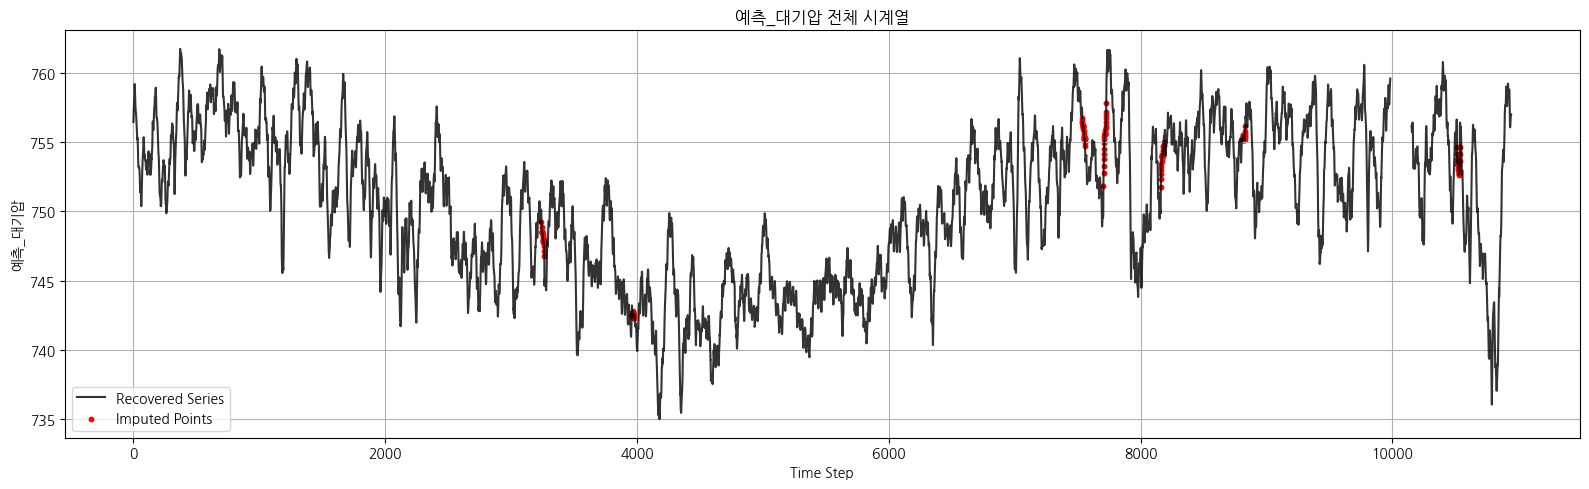

In [237]:
import numpy as np
import matplotlib.pyplot as plt

def recover_full_series(x_filled, mask, feature_idx):
    """
    x_filled : [N, L, C] - 모델 입력 (역정규화된 상태)
    mask     : [N, L, C] - 관측 여부 (1: 관측, 0: 결측)
    feature_idx : 시각화할 feature 인덱스 (예: 예측_기온 → 3)
    """
    N, L, C = x_filled.shape
    total_length = N + L - 1
    full_series = np.zeros(total_length)
    full_count = np.zeros(total_length)
    full_imputed_flags = np.zeros(total_length)

    for i in range(N):
        for j in range(L):
            t = i + j
            value = x_filled[i, j, feature_idx]
            full_series[t] += value
            full_count[t] += 1

            if mask[i, j, feature_idx] == 0:
                full_imputed_flags[t] = 1

    full_series = full_series / np.maximum(full_count, 1)
    return full_series, full_imputed_flags

def plot_full_series_with_imputed(full_series, imputed_flags, title="Full Imputed Series", ylabel="Value"):
    plt.figure(figsize=(16, 5))
    plt.plot(full_series, label="Recovered Series", color='black', alpha = 0.8)
    plt.scatter(
        np.where(imputed_flags == 1)[0],
        full_series[imputed_flags == 1],
        color='red', label="Imputed Points", s=10
    )
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print(predict_cols)
def make_full_series(column_name):
    feature_idx = predict_cols.index(column_name)
    full_series, imputed_flags = recover_full_series(x_recovered.numpy(), mask.numpy(), feature_idx)
    plot_full_series_with_imputed(full_series, imputed_flags, title=f"{column_name} 전체 시계열", ylabel=column_name)
    return full_series
for i in predict_cols:
  df[i] = make_full_series(i)

In [262]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 날짜 분해 함수 정의
def split_datetime_features(df):
    df = df.copy()
    df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])  # datetime 변환
    df['월'] = df['기상관측일시'].dt.month
    df['일'] = df['기상관측일시'].dt.day
    df['시'] = df['기상관측일시'].dt.hour
    return df

# 1. 날짜 분해
df = split_datetime_features(df)

# 2. 결측 있는 행은 타겟, 나머지는 학습용
target = df[df.isna().any(axis=1)]
train = df.dropna()

# 3. 학습용 데이터 분할
X_train, X_valid = train_test_split(train, test_size=0.2, shuffle=False)

# 4. 예측 컬럼 정의
predict_columns = [col for col in df.columns if col.startswith("예측_")]

# 5. 입력(feature) 컬럼 정의: 예측값/날짜 제외
drop_cols = ['기상관측일시'] + predict_columns
learning_columns = [col for col in df.columns if col not in drop_cols]

# 6. X, y 분리
y_train = X_train[predict_columns]
X_train = X_train[learning_columns]
y_valid = X_valid[predict_columns]
X_valid = X_valid[learning_columns]
target_X = target[learning_columns]  # 예측할 대상

# 확인
print("X_train shape:", X_train.shape)
print("사용된 feature columns:", learning_columns)

X_train shape: (8620, 6)
사용된 feature columns: ['관측_습도', '관측_기온', '관측_대기압', '월', '일', '시']


In [263]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

# 결과 저장용
df_filled = df.copy()

# 예측 대상 열
predict_columns = [col for col in df.columns if col.startswith("예측_")]

# 타겟 결측 행
target_rows = df[df.isna().any(axis=1)]
target_X = target_rows[learning_columns]

# 각 예측 컬럼별 반복
for col in predict_columns:
    # 결측인 부분만 대상으로 함
    if target_rows[col].isna().sum() == 0:
        continue  # 결측이 없는 경우 건너뜀

    print(f"Training model for column: {col}")

    # y: 현재 예측할 컬럼
    y_train_col = y_train[col]
    y_valid_col = y_valid[col]

    # 모델 정의
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        verbosity=0,
        n_jobs=-1
    )

    # 학습
    model.fit(X_train, y_train_col, eval_set=[(X_valid, y_valid_col)],  verbose=False)

    # 예측 및 결측값 채우기
    pred = model.predict(target_X)
    df_filled.loc[target_rows.index, col] = pred

Training model for column: 예측_일사량
Training model for column: 예측_습도
Training model for column: 예측_절대습도
Training model for column: 예측_기온
Training model for column: 예측_대기압


In [264]:
df_filled

,기상관측일시,관측_습도,관측_기온,관측_대기압,예측_일사량,예측_습도,예측_절대습도,예측_기온,예측_대기압,월,일,시
0,2024-01-01 00:00:00,85.23,3.82,764.46793,0.000000,57.061001,0.004000,0.803001,756.447693,1,1,0
1,2024-01-01 01:00:00,86.75,3.76,764.68855,0.000000,58.348000,0.004000,1.141000,756.926086,1,1,1
2,2024-01-01 02:00:00,86.43,3.04,765.05595,0.000000,58.896999,0.004000,1.417000,757.237183,1,1,2
3,2024-01-01 03:00:00,90.60,1.99,765.42151,0.000000,58.438000,0.004000,1.498000,757.490662,1,1,3
4,2024-01-01 04:00:00,92.59,1.25,765.61559,0.000000,58.285999,0.004000,1.172000,757.593994,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10940,2025-03-31 20:00:00,38.48,9.89,762.69059,0.000000,41.709999,0.004000,6.140000,756.721985,3,31,20
10941,2025-03-31 21:00:00,44.51,8.76,763.16659,0.000000,45.688000,0.004000,4.839000,756.883850,3,31,21
10942,2025-03-31 22:00:00,51.41,7.92,763.54106,0.000000,48.203999,0.004000,4.344000,756.949280,3,31,22
10943,2025-03-31 23:00:00,56.36,6.76,763.63648,0.000000,48.858002,0.004000,3.901999,757.015442,3,31,23


In [265]:
import matplotlib.pyplot as plt
import numpy as np

def plot_each_prediction_series(df, pred_cols):
    """
    df : DataFrame (예측값 포함, 결측치 이미 채워짐)
    pred_cols : 예측 컬럼 리스트 (예: ['예측_일사량', '예측_습도', ...])
    """
    for col in pred_cols:
        series = df[col].values
        nan_flags = df[col].isna().astype(int).values  # 예전 결측치 위치

        plt.figure(figsize=(16, 5))
        plt.plot(series, label='Recovered Series', color='black', alpha=0.8)
        plt.scatter(
            np.where(nan_flags == 1)[0],
            series[nan_flags == 1],
            color='red', label='Imputed Points', s=10
        )
        plt.title(f"{col} 전체 시계열")
        plt.xlabel("Time Step")
        plt.ylabel(col)
        plt.legend()
        plt.grid(True)
        plt.subplots_adjust(bottom=0.15)  # tight_layout 대체
        plt.show()

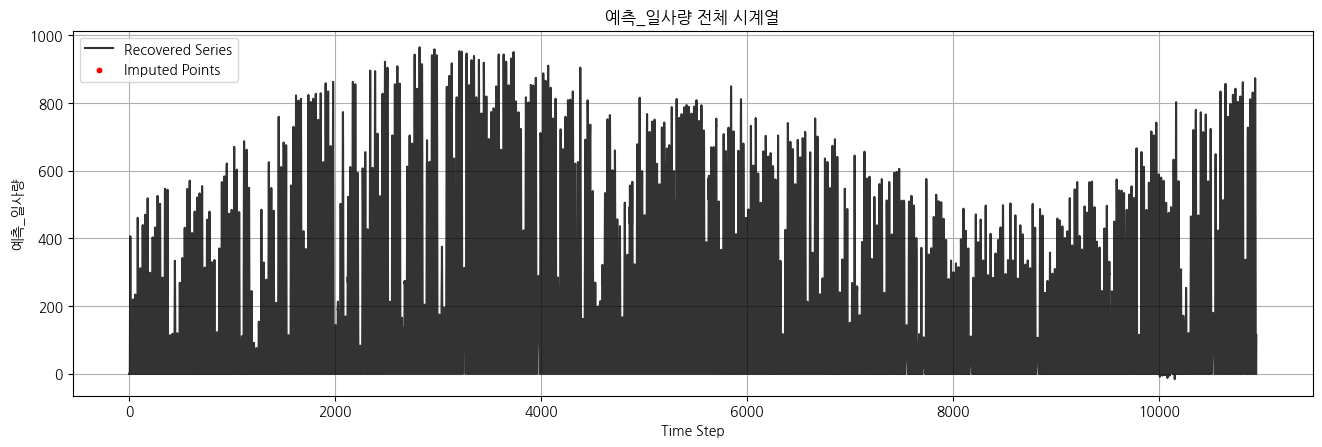

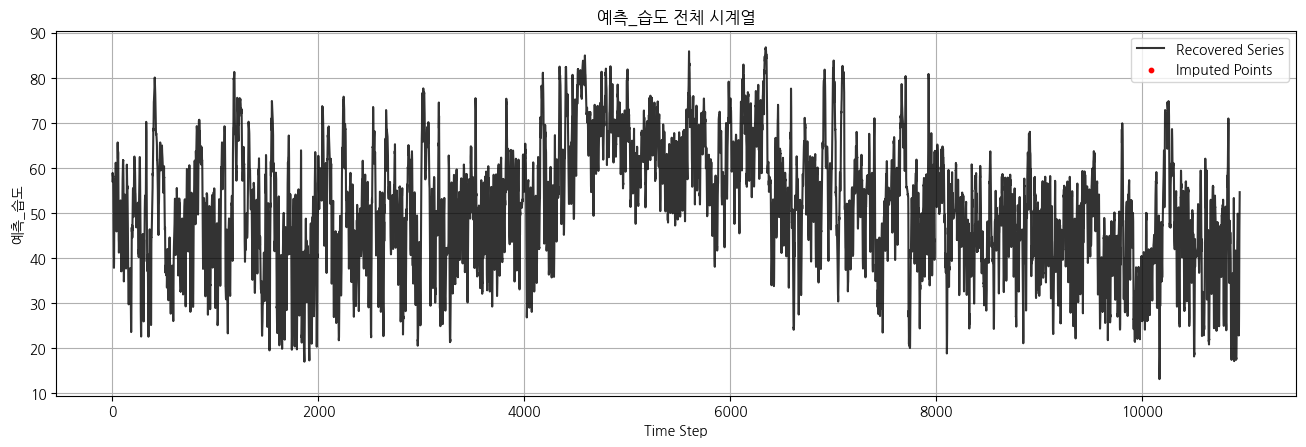

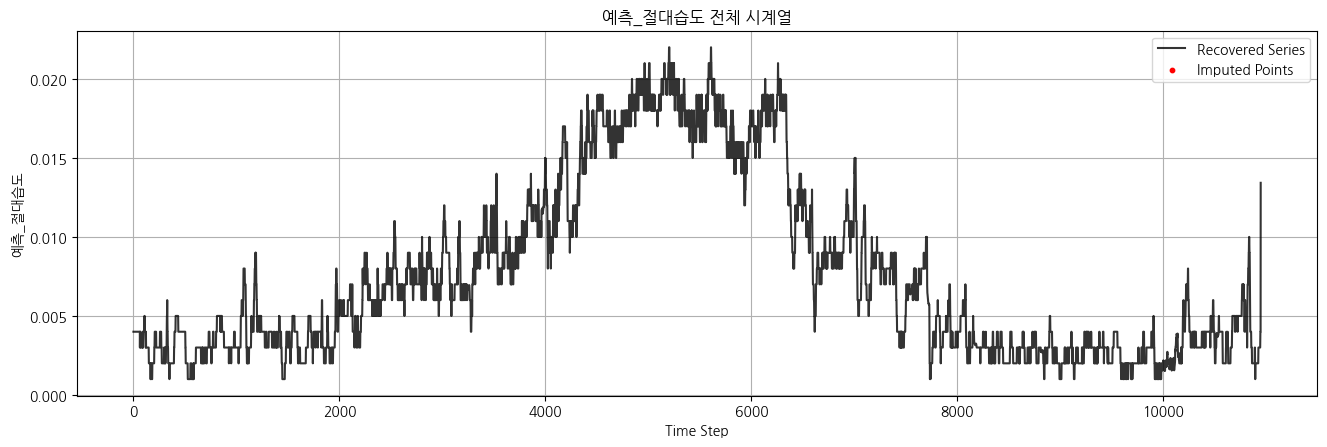

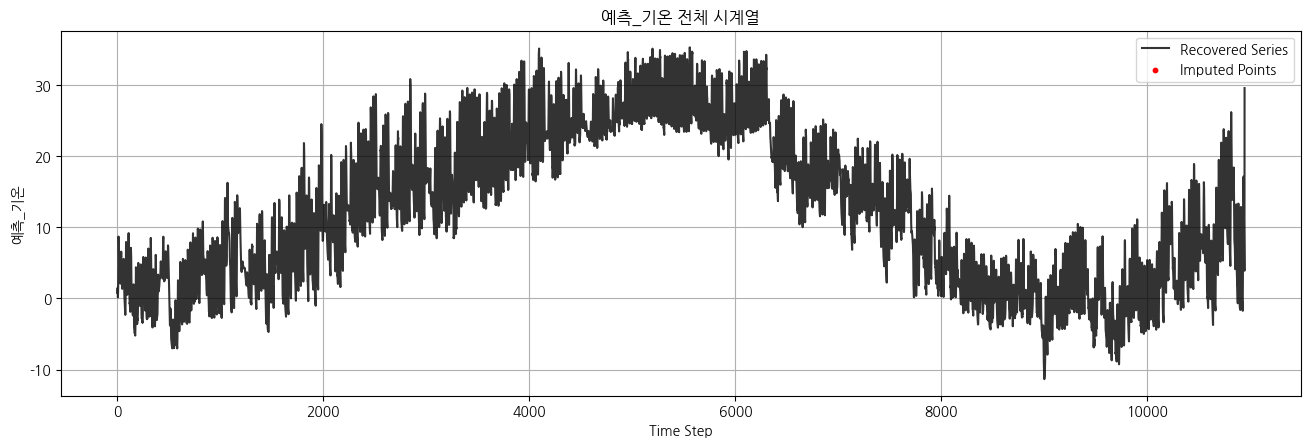

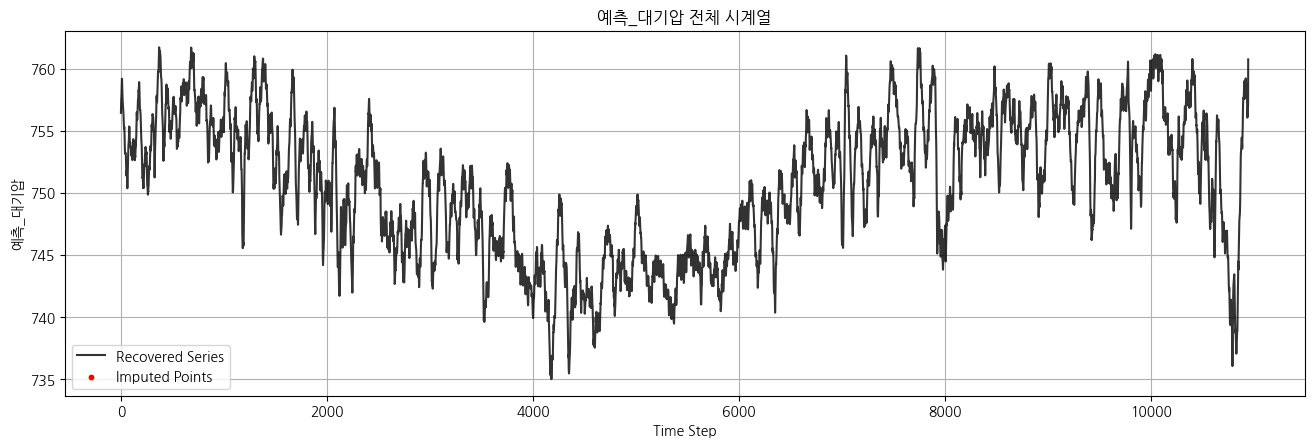

In [266]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecast_column(df, pred_cols):
    """
    df : DataFrame (예측값 포함, 결측치 이미 채워짐)
    pred_cols : 예측 컬럼 리스트 (예: ['예측_일사량', '예측_습도', ...])
    """
    for col in pred_cols:
        series = df[col].values
        nan_flags = df[col].isna().astype(int).values  # 예전 결측치 위치

        plt.figure(figsize=(16, 5))
        plt.plot(series, label='Recovered Series', color='black', alpha=0.8)
        plt.scatter(
            np.where(nan_flags == 1)[0],
            series[nan_flags == 1],
            color='red', label='Imputed Points', s=10
        )
        plt.title(f"{col} 전체 시계열")
        plt.xlabel("Time Step")
        plt.ylabel(col)
        plt.legend()
        plt.grid(True)
        plt.subplots_adjust(bottom=0.15)  # tight_layout 대체
        plt.show()

# 1. 컬럼 이름 공백 제거 (문제 방지용)
df_filled.columns = df_filled.columns.str.strip()

# 2. 예측 컬럼 리스트 추출
pred_cols = [col for col in df_filled.columns if col.startswith("예측_")]

# 3. 시각화 함수 실행
plot_forecast_column(df_filled, pred_cols)

In [268]:
df_filled.to_csv('공모전_data.csv', index=False)

In [269]:
df_filled

,기상관측일시,관측_습도,관측_기온,관측_대기압,예측_일사량,예측_습도,예측_절대습도,예측_기온,예측_대기압,월,일,시
0,2024-01-01 00:00:00,85.23,3.82,764.46793,0.000000,57.061001,0.004000,0.803001,756.447693,1,1,0
1,2024-01-01 01:00:00,86.75,3.76,764.68855,0.000000,58.348000,0.004000,1.141000,756.926086,1,1,1
2,2024-01-01 02:00:00,86.43,3.04,765.05595,0.000000,58.896999,0.004000,1.417000,757.237183,1,1,2
3,2024-01-01 03:00:00,90.60,1.99,765.42151,0.000000,58.438000,0.004000,1.498000,757.490662,1,1,3
4,2024-01-01 04:00:00,92.59,1.25,765.61559,0.000000,58.285999,0.004000,1.172000,757.593994,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10940,2025-03-31 20:00:00,38.48,9.89,762.69059,0.000000,41.709999,0.004000,6.140000,756.721985,3,31,20
10941,2025-03-31 21:00:00,44.51,8.76,763.16659,0.000000,45.688000,0.004000,4.839000,756.883850,3,31,21
10942,2025-03-31 22:00:00,51.41,7.92,763.54106,0.000000,48.203999,0.004000,4.344000,756.949280,3,31,22
10943,2025-03-31 23:00:00,56.36,6.76,763.63648,0.000000,48.858002,0.004000,3.901999,757.015442,3,31,23



🔍 Target: 관측_기온

🔍 Target: 관측_습도

🔍 Target: 관측_대기압
✅ MSE: 0.5138
✅ RMSE: 0.7168


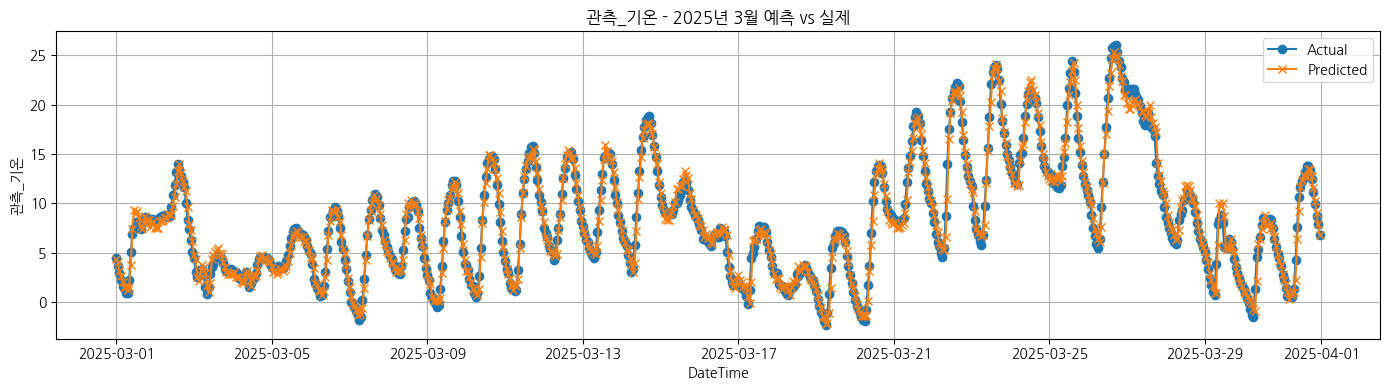

✅ MSE: 16.0348
✅ RMSE: 4.0044


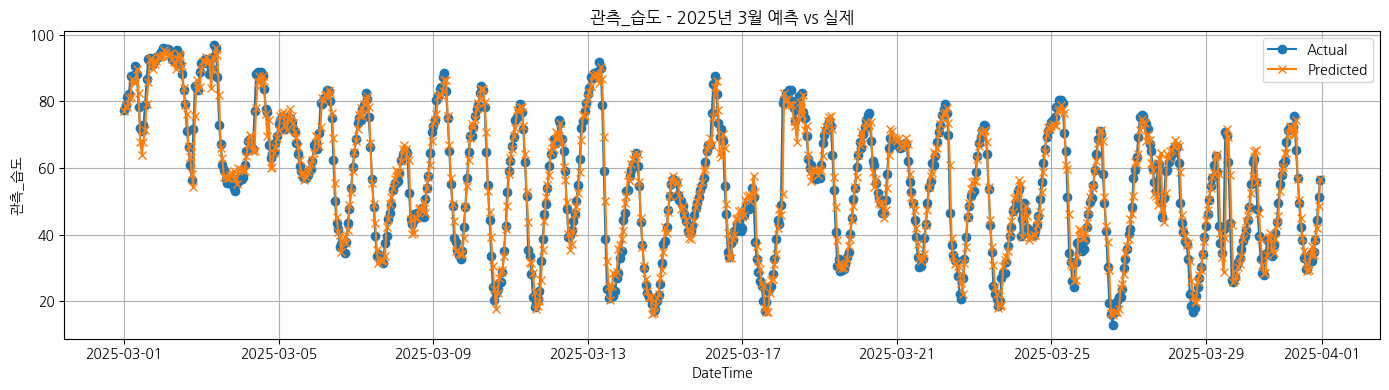

✅ MSE: 0.1375
✅ RMSE: 0.3707


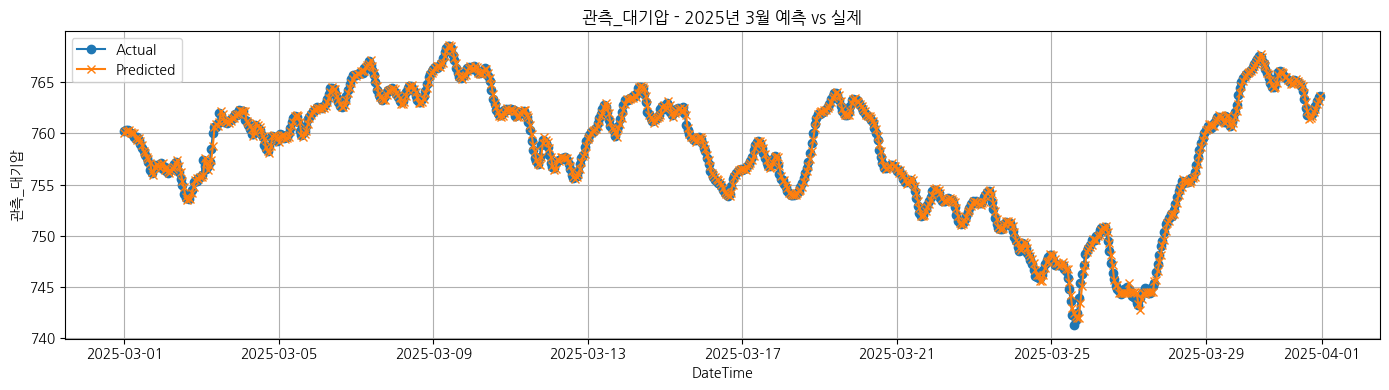

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# 복사 및 시간 인덱스 설정
df = df_filled.copy()
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df.set_index('기상관측일시', inplace=True)

# 타깃 변수 리스트
target_cols = ['관측_기온', '관측_습도', '관측_대기압']

# 결과 저장용
results = {}

# 각 타깃 변수에 대해 반복
for target_col in target_cols:
    print(f"\n🔍 Target: {target_col}")

    # Lag feature 생성
    for lag in range(1, 25):
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)

# 결측 제거 (모든 lag-feature 고려 후)
df = df.dropna()

# 테스트/학습 데이터 분리
test_df = df[(df.index.year == 2025) & (df.index.month == 3)]
train_df = df[df.index < test_df.index.min()]

for target_col in target_cols:
    feature_cols = [f'{target_col}_lag{lag}' for lag in range(1, 25)]

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    # 모델 학습
    model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 평가
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[target_col] = {'mse': mse, 'rmse': rmse}

    print(f"✅ MSE: {mse:.4f}")
    print(f"✅ RMSE: {rmse:.4f}")

    # 시각화
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
    plt.title(f'{target_col} - 2025년 3월 예측 vs 실제')
    plt.xlabel('DateTime')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()